# inter subject 测试


## 加载各种包

In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
# from sklearn.preprocessing import label_binarize
# from sklearn import preprocessing
# from sklearn import tree 

import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as scio
# import hiddenlayer as h
from visdom import Visdom
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from torchviz import make_dot

import datetime
import os 

import sys
from utils.reuse import *
from utils.networks import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 预备操作
设置检查点、visdom 日志文件存储等日志性文件存储位置；
初始化 visdom,记得先在命令行输入 visdom 运行（python环境下）

In [2]:
# 以下是检查点路径
# 请在当前环境下 CMD 输入python -m visdom.server 或 visdom 启动监视器
# 数据处理现在已移至 emgDataprocess.ipynb
model_Dir = ".//model//emgmk_cnn_0410_nl//"
if not os.path.exists(model_Dir):
    os.makedirs(model_Dir)

ckpDir = model_Dir + "ckp//"
if not os.path.exists(ckpDir):
    os.makedirs(ckpDir)

ckpDir_auc = ".//ckp//emgmk_cnn_0323_nl//auc//"
if not os.path.exists(ckpDir_auc):
    os.makedirs(ckpDir_auc)


def get_current_time():
    return datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")


print(get_current_time())

timeForSave = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

2022_04_26_22_05_55


## 上肢测试

### 定义神经网络结构


In [3]:
# 自定义神经网络,CNN
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


# hdreshape = 32*1*3
# hdreshape = 2
# hdlayer_1 = 16
# hdlayer_2 = 16
# hdlayer_3 = 256
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=128, kernel_size=3, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=0
        )

        self.fc1 = nn.Linear(in_features=128 * 1 * 6, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        # self.fc3 = nn.Linear(in_features=hdlayer_2, out_features=hdlayer_3)
        self.out = nn.Linear(in_features=128, out_features=6)
        self.dr1 = nn.Dropout2d(0.2)

    def forward(self, t):
        # (1) input layer
        t = t
        # t = t.reshape(1,1,3)
        # t = t.unsqueeze(0)

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (3) hidden conv layer
        # t = self.conv2(t)
        # t = F.relu(t)
        # t = self.dr1(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (4) hidden linear layer
        t = t.reshape(-1, 128 * 1 * 6)
        # t = t.flatten(start_dim=0)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        # t = self.fc3(t)
        # t = F.relu(t)
        # t = self.dr1(t)

        # (5) output layer
        t = self.out(t)

        return t


net = Network()
# 打印网络，检查输入输出 shape是否正确
# print(net)
samplebatchsize = 1
summary(net, (1, 1, 6), batch_size=samplebatchsize, device="cpu")
sampleInput = torch.randn(samplebatchsize, 1, 1, 6).requires_grad_(True)
sampleOutput = net(sampleInput)
print("Outputshape:", sampleOutput.shape)
# framevision = make_dot(sampleOutput, params=dict(list(net.named_parameters()) + [('x',sampleInput)]))
# framevision.format = "png"
# framevision.direcory = "./"
# framevision.view()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 128, 1, 6]           1,280
            Linear-2                   [1, 128]          98,432
            Linear-3                   [1, 128]          16,512
            Linear-4                     [1, 6]             774
Total params: 116,998
Trainable params: 116,998
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.45
----------------------------------------------------------------
Outputshape: torch.Size([1, 6])


## 数据集加载、构建

In [10]:
# 上肢和下肢数据不同，这是上肢数据
dataarray = np.load(
    "../data/WristDataForPINN-1/EMGSKdata-220426-s4t2-slim.npy", allow_pickle=True
)
CNNdataset = dataarray.item()
print(type(CNNdataset))
# 加载自变量：因为数据头尾不少空缺，裁剪之
data_head = 11
data_end = 2000
data_time = CNNdataset["time"]  # [data_head:data_end]
data_fcr = CNNdataset["fcr"]  # [data_head:data_end]
data_fcu = CNNdataset["fcu"]  # [data_head:data_end]
data_ecrl = CNNdataset["ecrl"]  # [data_head:data_end]
data_ecrb = CNNdataset["ecrb"]  # [data_head:data_end]
data_ecu = CNNdataset["ecu"]  # [data_head:data_end]
data_angle = CNNdataset["angle"]  # [data_head:data_end]
data_mf_fcr = CNNdataset["mf_fcr"]  # [data_head:data_end]
data_mf_fcu = CNNdataset["mf_fcu"]  # [data_head:data_end]
data_mf_ecrl = CNNdataset["mf_ecrl"]  # [data_head:data_end]
data_mf_ecrb = CNNdataset["mf_ecrb"]  # [data_head:data_end]
data_mf_ecu = CNNdataset["mf_ecu"]  # [data_head:data_end]
# 弧度转角度
data_angle = data_angle / (2 * np.pi) * 360

<class 'dict'>


In [11]:
# 划分训练集与测试集，每5点抽取一点作为测试集
def DataSpliter(data):
    data_tr = []
    data_te = []
    for i in range(len(data)):
        if (i + 1) % 5 == 0:
            data_te.append(data[i, :])
        else:
            data_tr.append(data[i, :])
    data_tr = np.array(data_tr)
    data_te = np.array(data_te)
    return data_tr, data_te


# 自变量部分
tr_data_time, te_data_time = DataSpliter(data_time)
tr_data_fcr, te_data_fcr = DataSpliter(data_fcr)
tr_data_fcu, te_data_fcu = DataSpliter(data_fcu)
tr_data_ecrl, te_data_ecrl = DataSpliter(data_ecrl)
tr_data_ecrb, te_data_ecrb = DataSpliter(data_ecrb)
tr_data_ecu, te_data_ecu = DataSpliter(data_ecu)
# 因变量部分
tr_data_angle, te_data_angle = DataSpliter(data_angle)
tr_data_mf_fcr, te_data_mf_fcr = DataSpliter(data_mf_fcr)
tr_data_mf_fcu, te_data_mf_fcu = DataSpliter(data_mf_fcu)
tr_data_mf_ecrl, te_data_mf_ecrl = DataSpliter(data_mf_ecrl)
tr_data_mf_ecrb, te_data_mf_ecrb = DataSpliter(data_mf_ecrb)
tr_data_mf_ecu, te_data_mf_ecu = DataSpliter(data_mf_ecu)
print(tr_data_mf_ecu.shape, te_data_ecu.shape)
# 按需组合数据，这两函数其实可以合并成一个
def Data_conbine(data_1, data_2, data_3, data_4, data_5, data_6):
    data_train = []
    for i in range(len(data_1)):
        data_1t6 = np.hstack(
            (
                data_1[i, :],
                data_2[i, :],
                data_3[i, :],
                data_4[i, :],
                data_5[i, :],
                data_6[i, :],
            )
        )
        data_1t6 = data_1t6.flatten()
        data_train.append(data_1t6)
    data_train = np.array(data_train)
    return data_train


def Data_conbine_5v(data_1, data_2, data_3, data_4, data_5):
    data_train = []
    for i in range(len(data_1)):
        data_1t6 = np.hstack(
            (data_1[i, :], data_2[i, :], data_3[i, :], data_4[i, :], data_5[i, :])
        )
        data_1t6 = data_1t6.flatten()
        data_train.append(data_1t6)
    data_train = np.array(data_train)
    return data_train


# 多时间步组建数据，这个在这里暂时没用上，因此我把它暂时注掉了
# def establish_multi_timestep_data(data_X,data_X_2,data_Y,expect_time_length):
#     dataset = []
#     dataset_y = []
#     if expect_time_length >0:
#         length = len(data_X)-expect_time_length
#         for i in range(length):
#             data_1 = data_X[i:i+expect_time_length,:]
#             data_1 = data_1.flatten()
#             data_2 = data_X_2[i:i+expect_time_length,:]
#             data_2 = data_2.flatten()
#             data_12 = np.hstack((data_1,data_2))
#             dataset.append(data_12)
#             dataset_y.append(data_Y[i+expect_time_length-1,:])
#         dataset = np.array(dataset)
#         dataset_y = np.array(dataset_y)
#     return dataset, dataset_y
# 将自变量与因变量各自组合到一起，尺寸均为1*6
data_1t6_tr = Data_conbine(
    tr_data_time, tr_data_fcr, tr_data_fcu, tr_data_ecrl, tr_data_ecrb, tr_data_ecu
)
data_1t6_te = Data_conbine(
    te_data_time, te_data_fcr, te_data_fcu, te_data_ecrl, te_data_ecrb, te_data_ecu
)
data_7t12_tr = Data_conbine(
    tr_data_angle,
    tr_data_mf_fcr,
    tr_data_mf_fcu,
    tr_data_mf_ecrl,
    tr_data_mf_ecrb,
    tr_data_mf_ecu,
)
data_7t12_te = Data_conbine(
    te_data_angle,
    te_data_mf_fcr,
    te_data_mf_fcu,
    te_data_mf_ecrl,
    te_data_mf_ecrb,
    te_data_mf_ecu,
)
data_8t12_tr = Data_conbine_5v(
    tr_data_mf_fcr, tr_data_mf_fcu, tr_data_mf_ecrl, tr_data_mf_ecrb, tr_data_mf_ecu
)
data_8t12_te = Data_conbine_5v(
    te_data_mf_fcr, te_data_mf_fcu, te_data_mf_ecrl, te_data_mf_ecrb, te_data_mf_ecu
)
# 转为 tensor 格式
data_1t6_tr = torch.from_numpy(data_1t6_tr).to(torch.float32)
data_1t6_te = torch.from_numpy(data_1t6_te).to(torch.float32)
data_7t12_tr = torch.from_numpy(data_7t12_tr).to(torch.float32)
data_7t12_te = torch.from_numpy(data_7t12_te).to(torch.float32)

print(data_1t6_tr.shape, data_7t12_tr.shape, data_1t6_te.shape, data_7t12_te.shape)

# # 需要一个指示前一时刻的标签，居然没注意到 cyc 每五取一后不再连续了，害
data_index_tr = np.linspace(0, 1591, 1592)
data_index_te = np.linspace(0, 396, 397)

(160, 1) (40, 1)
torch.Size([160, 6]) torch.Size([160, 6]) torch.Size([40, 6]) torch.Size([40, 6])


In [12]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # 将图片转换为Tensor,归一化至[0,1]
    ]
)


class EMGSK_Dataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y
        self.transforms = transform

    def __getitem__(self, index):
        sample_x = self.data_x[index, :]
        sample_y = self.data_y[index, :]
        # for CNN
        sample_x = sample_x.unsqueeze(0)
        sample_x = sample_x.numpy()
        sample_x = self.transforms(sample_x)
        # 一维数据用下面的这个就行
        # emgData = torch.Tensor(emgData)
        return sample_x, sample_y

    def __len__(self):
        return len(self.data_x)


class EMGSK_nl_Dataset(Dataset):
    def __init__(self, data_x, data_y, data_idx):
        self.data_x = data_x
        self.data_y = data_y
        self.data_angle = self.data_y[:, 0]
        self.data_time = self.data_x[:, 0]
        self.data_mf = self.data_y[:, 1:6]
        self.data_idx = data_idx
        self.transforms = transform

    def __getitem__(self, index):
        sample_x = self.data_x[index, :]
        sample_y = self.data_y[index, :]
        sample_mf = self.data_mf[index, :]
        sample_angle = self.data_angle[index]
        sample_time = self.data_time[index]
        sample_idx = self.data_idx[index]
        # for CNN
        sample_x = sample_x.unsqueeze(0)
        sample_x = sample_x.numpy()
        sample_x = self.transforms(sample_x)
        # 一维数据用下面的这个就行
        # emgData = torch.Tensor(emgData)
        return sample_x, sample_y, sample_mf, sample_time, sample_angle, sample_idx

    def __len__(self):
        return len(self.data_x)


train_set = EMGSK_nl_Dataset(data_1t6_tr, data_7t12_tr, data_index_tr)
test_set = EMGSK_nl_Dataset(data_1t6_te, data_7t12_te, data_index_te)

sample = iter(test_set)

print(sample)

In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=False)
batch1 = iter(train_loader)
# dassy_2 = data_457_tr_y[:,2]

In [9]:
batch2 = next(batch1)
d_x, d_y, d_mf, d_t, d_a, d_i = batch2
print(
    "x:",
    d_x.shape,
    d_x,
    "\n",
    "y:",
    d_y.shape,
    d_y,
    "\n",
    "mf:",
    d_mf.shape,
    d_mf,
    "\n",
    "t:",
    d_t.shape,
    d_t,
    "\n",
    "idx:",
    d_i.shape,
    d_i,
    "\n",
    "a:",
    d_a.shape,
    d_a,
)

x: torch.Size([2, 1, 1, 6]) tensor([[[[0.0010, 0.0007, 0.0008, 0.0050, 0.0071, 0.0010]]],


        [[[0.0098, 0.0024, 0.0019, 0.0281, 0.0205, 0.0029]]]]) 
 y: torch.Size([2, 6]) tensor([[-12.7747,   6.2070,   1.6332,   4.3495,   9.6121,   0.5148],
        [-26.4991,  13.4294,   3.7292,  23.8853,  26.0026,   1.4287]]) 
 mf: torch.Size([2, 5]) tensor([[ 6.2070,  1.6332,  4.3495,  9.6121,  0.5148],
        [13.4294,  3.7292, 23.8853, 26.0026,  1.4287]]) 
 t: torch.Size([2]) tensor([0.0010, 0.0098]) 
 idx: torch.Size([2]) tensor([0., 1.], dtype=torch.float64) 
 a: torch.Size([2]) tensor([-12.7747, -26.4991])


### 他人数据验证
展示训练效果，保存模型文件等等

In [36]:
# omse
# emgsk_upper200_oMSE_2022_04_25_20_39_01
checkpoint_for_net2 = torch.load(
    model_Dir + "emgsk_upper200_oMSE_2022_04_25_20_39_01.pth"
)
# nl
# checkpoint_for_net2 = torch.load(model_Dir+'ckp//'+'emgsk_ep_900_2022_04_25_20_39_01.pth')
net2 = Network()
net2.load_state_dict(checkpoint_for_net2)
# net2.load_state_dict(checkpoint_for_net2['model'])
net2.eval()

Network(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=6, bias=True)
  (dr1): Dropout2d(p=0.2, inplace=False)
)

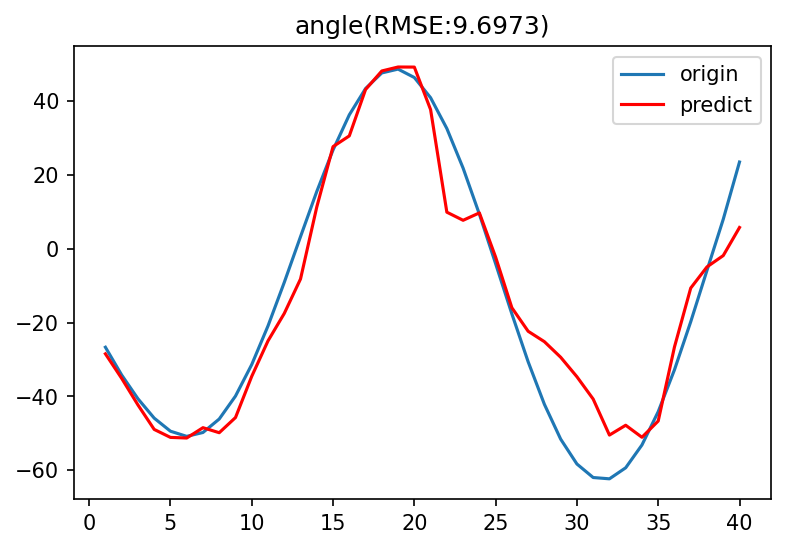

In [37]:
show_x = data_1t6_te
show_y = data_7t12_te
show_l = 40  # 397
column = 0
# net3 = net
mf_namelist = ["angle", "fcr", "fcu", "ecrl", "ecrb", "ecu"]
net = net2
net.eval()
net.to("cpu")
criterion = torch.nn.MSELoss()
# predict = net(show_x)
# predict = predict.data.numpy()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)
predict_show = []
y_show = []
for batch in test_loader:
    s_x, s_y, s_mf, _, _, _ = batch
    # s_y = s_mf
    predict = net(s_x)
    pred2 = predict.detach().numpy()
    predict_show.append(pred2)
    trainloss = criterion(predict, s_y)
    y_s = s_y.detach().numpy()
    y_show.append(y_s)
predict_show = np.array(predict_show)
y_show = np.array(y_show)
# MSE_show = criterion(torch.Tensor(predict_show[:,column]), torch.Tensor(y_show[:,column]))
MSE_show = criterion(
    torch.Tensor(predict_show[:, :, column]), torch.Tensor(y_show[:, :, column])
)
predict = predict.data.numpy()
# 建立等差数列，（起始，终止，个数）
x = np.linspace(1, show_l, show_l)
plt.rcParams["figure.dpi"] = 150
plt.title(mf_namelist[column] + "(RMSE:" + str("%.5g" % torch.sqrt(MSE_show)) + ")")
# plt.plot(x , show_y[:,column], label='origin')
plt.plot(x, show_y[:, column], label="origin")
# plt.plot(x, predict[:,column], color='red', label='predict')
plt.plot(x, predict_show[:, 0, column], color="red", label="predict")
plt.legend()
plt.show()

In [33]:
adataset_kmmf = {}
data_7t12_te = np.array(data_7t12_te)
adataset_kmmf["GT"] = data_7t12_te
adataset_kmmf["Preds"] = predict_show
np.save("../data/exportdata/ul_rf_slim_s4t2.npy", adataset_kmmf)

In [34]:
from scipy import io

mat = np.load("../data/exportdata/ul_rf_slim_s4t2.npy", allow_pickle=True)
io.savemat("../data/exportdata/ul_rf_slim_s4t2.mat", {"variables": mat})

In [18]:
# checkpointPath_model = model_Dir+'emgsk_fornl_CNN_01'+'_nl_agle_re'+timeForSave+'.pth'
# torch.save(net.state_dict(),checkpointPath_model)
checkpointPath_model = model_Dir + "emgsk_upper200" + "_oMSE_" + timeForSave + ".pth"
torch.save(net.state_dict(), checkpointPath_model)

In [17]:
# emgsk_ep_100_2022_04_15_21_20_17
# emgsk_ep_200_2022_04_15_21_35_13
# checkpoint_for_net2 = torch.load(model_Dir+'ckp//'+'emgsk_ep_600_2022_04_17_12_00_58.pth')
checkpoint_for_net2 = torch.load(
    model_Dir + "ckp//" + "emgsk_ep_800_2022_04_24_13_56_04.pth"
)
net2 = Network()
# net2.load_state_dict(checkpoint_for_net2)
net2.load_state_dict(checkpoint_for_net2["model"])
net2.eval()

Network(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=6, bias=True)
  (dr1): Dropout2d(p=0.2, inplace=False)
)

In [1]:

#对网络进行验证
# column = 0
# show_x = data_123_te
# show_y = data_45_te_y
# show_l = 20
# net.eval()
# net.to('cpu')
# predict = net(show_x)
# # predict = predict.data.numpy()

# # MSE_show = criterion(predict[:,column], show_y[:,column])
# MSE_show = criterion(predict, show_y)
# predict = predict.data.numpy()
# # 建立等差数列，（起始，终止，个数）
# x = np.linspace(1,show_l,show_l)
# # column = 0
# plt.title('MF(RMSE:'+str('%.5g' % torch.sqrt(MSE_show))+')')
# # plt.plot(x , show_y[:,column], label='origin')
# plt.plot(x , show_y, label='origin')
# # plt.plot(x, predict[:,column], color='red', label='predict')
# plt.plot(x, predict, color='red', label='predict')
# plt.legend()
# plt.show()


## 下肢
###

In [52]:
dataarray = np.load(
    "../data/220319emgsk/withTrueTime/EMGSKdata-220426_s3f4.npy", allow_pickle=True
)
CNNdataset = dataarray.item()
print(type(CNNdataset))
# 加载自变量：
data_cyc = CNNdataset["data_cyc"]
data_emg_rf_l = CNNdataset["data_emg_rf_l"]
data_emg_lh_l = CNNdataset["data_emg_lh_l"]
data_mf_rf_l = CNNdataset["data_mf_rf_l"]
data_mf_bm_l = CNNdataset["data_mf_bm_l"]
data_ka_l = CNNdataset["data_ka_l"]
data_time = CNNdataset["data_time"]

# 划分训练集与测试集
def DataSpliter(data):
    data_tr = []
    data_te = []
    for i in range(len(data)):
        if (i + 1) % 5 == 0:
            data_te.append(data[i, :])
        else:
            data_tr.append(data[i, :])
    data_tr = np.array(data_tr)
    data_te = np.array(data_te)
    return data_tr, data_te


tr_cyc, te_cyc = DataSpliter(data_cyc)
print(tr_cyc.shape, te_cyc.shape)
tr_mf_bm_l, te_mf_bm_l = DataSpliter(data_mf_bm_l)
tr_emg_rf_l, te_emg_rf_l = DataSpliter(data_emg_rf_l)
tr_emg_lh_l, te_emg_lh_l = DataSpliter(data_emg_lh_l)
tr_mf_rf_l, te_mf_rf_l = DataSpliter(data_mf_rf_l)
tr_ka_l, te_ka_l = DataSpliter(data_ka_l)
# 新增部分，常量的部分数据也需要跟随划分成训练集和测试集
tr_data_time, te_data_time = DataSpliter(data_time)
# 按需组合数据，这两函数其实可以合并成一个
def Data_conbine(data_1, data_2):
    data_train = []
    for i in range(len(data_1)):
        data_1_2 = np.hstack((data_1[i, :], data_2[i, :]))
        data_1_2 = data_1_2.flatten()
        data_train.append(data_1_2)
    data_train = np.array(data_train)
    return data_train


def establish_multi_timestep_data(data_X, data_X_2, data_Y, expect_time_length):
    dataset = []
    dataset_y = []
    if expect_time_length > 0:
        length = len(data_X) - expect_time_length
        for i in range(length):
            data_1 = data_X[i : i + expect_time_length, :]
            data_1 = data_1.flatten()
            data_2 = data_X_2[i : i + expect_time_length, :]
            data_2 = data_2.flatten()
            data_12 = np.hstack((data_1, data_2))
            dataset.append(data_12)
            dataset_y.append(data_Y[i + expect_time_length - 1, :])
        dataset = np.array(dataset)
        dataset_y = np.array(dataset_y)
    return dataset, dataset_y


data_12_tr = Data_conbine(tr_cyc, tr_emg_rf_l)
data_12_te = Data_conbine(te_cyc, te_emg_rf_l)
data_13_tr = Data_conbine(tr_cyc, tr_emg_lh_l)
data_13_te = Data_conbine(te_cyc, te_emg_lh_l)
data_123_tr = Data_conbine(data_12_tr, tr_emg_lh_l)
data_123_te = Data_conbine(data_12_te, te_emg_lh_l)
data_45_tr_y = Data_conbine(tr_mf_rf_l, tr_mf_bm_l)
data_45_te_y = Data_conbine(te_mf_rf_l, te_mf_bm_l)
data_457_tr_y = Data_conbine(data_45_tr_y, tr_ka_l)
data_457_te_y = Data_conbine(data_45_te_y, te_ka_l)

data_13_tr_5t, data_13_tr_5t_y = establish_multi_timestep_data(
    tr_cyc, tr_emg_lh_l, tr_mf_bm_l, 5
)
data_13_te_5t, data_13_te_5t_y = establish_multi_timestep_data(
    te_cyc, te_emg_lh_l, te_mf_bm_l, 5
)
print(data_13_tr_5t.shape, data_13_te_5t_y.shape)
# 转为 tensor 格式
data_12_tr = torch.from_numpy(data_12_tr)
data_12_te = torch.from_numpy(data_12_te)
data_13_tr = torch.from_numpy(data_13_tr)
data_13_te = torch.from_numpy(data_13_te)
data_123_tr = torch.from_numpy(data_123_tr)
data_123_te = torch.from_numpy(data_123_te)
tr_mf_rf_l = torch.from_numpy(tr_mf_rf_l)
te_mf_rf_l = torch.from_numpy(te_mf_rf_l)
tr_mf_bm_l = torch.from_numpy(tr_mf_bm_l)
te_mf_bm_l = torch.from_numpy(te_mf_bm_l)
tr_ka_l = torch.from_numpy(tr_ka_l)
te_ka_l = torch.from_numpy(te_ka_l)

data_12_tr = data_12_tr.to(torch.float32)
data_12_te = data_12_te.to(torch.float32)
data_13_tr = data_13_tr.to(torch.float32)
data_13_te = data_13_te.to(torch.float32)
data_123_tr = data_123_tr.to(torch.float32)
data_123_te = data_123_te.to(torch.float32)
tr_mf_rf_l = tr_mf_rf_l.to(torch.float32)
te_mf_rf_l = te_mf_rf_l.to(torch.float32)
tr_mf_bm_l = tr_mf_bm_l.to(torch.float32)
te_mf_bm_l = te_mf_bm_l.to(torch.float32)
tr_ka_l = tr_ka_l.to(torch.float32)
te_ka_l = te_ka_l.to(torch.float32)

data_13_tr_5t = torch.from_numpy(data_13_tr_5t).to(torch.float32)
data_13_te_5t = torch.from_numpy(data_13_te_5t).to(torch.float32)
data_13_tr_5t_y = torch.from_numpy(data_13_tr_5t_y).to(torch.float32)
data_13_te_5t_y = torch.from_numpy(data_13_te_5t_y).to(torch.float32)


data_45_tr_y = torch.from_numpy(data_45_tr_y).to(torch.float32)
data_45_te_y = torch.from_numpy(data_45_te_y).to(torch.float32)
data_457_tr_y = torch.from_numpy(data_457_tr_y).to(torch.float32)
data_457_te_y = torch.from_numpy(data_457_te_y).to(torch.float32)

print(data_12_te.shape, data_13_tr.shape, data_123_tr.shape)

# 需要一个指示前一时刻的标签，居然没注意到 cyc 每五取一后不再连续了，害
data_index_tr = np.linspace(0, 80, 81)
data_index_te = np.linspace(0, 19, 20)

<class 'dict'>
(81, 1) (20, 1)
(76, 10) (15, 1)
torch.Size([20, 2]) torch.Size([81, 2]) torch.Size([81, 3])


In [53]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # 将图片转换为Tensor,归一化至[0,1]
    ]
)


class EMGSK_Dataset(Dataset):
    def __init__(
        self, data_x, data_y, data_Ma, data_Cv, data_G_theta, data_M_Arf, data_M_Abif
    ):
        self.data_x = data_x
        self.data_y = data_y
        self.data_Ma = data_Ma
        self.data_Cv = data_Cv
        self.data_G_theta = data_G_theta
        self.data_M_Arf = data_M_Arf
        self.data_M_Abif = data_M_Abif

        self.transforms = transform

    def __getitem__(self, index):
        sample_x = self.data_x[index, :]
        sample_y = self.data_y[index, :]
        sample_Ma = self.data_Ma[index, :]
        sample_Cv = self.data_Cv[index, :]
        sample_G_theta = self.data_G_theta[index, :]
        sample_M_Arf = self.data_M_Arf[index, :]
        sample_M_Abif = self.data_M_Abif[index, :]

        # for CNN
        sample_x = sample_x.unsqueeze(0)
        sample_x = sample_x.numpy()
        sample_x = self.transforms(sample_x)

        # kmmf_Data = self.data_sample[index,:,:]
        # kmmfData = np.squeeze(kmmfData)
        # kmmf_label = self.data_label[index]
        # kmmf_label = kmmf_label.astype(np.int16)
        # kmmf_Data = self.transforms(kmmf_Data)
        # kmmf_label = self.transforms(kmmf_label)
        # 一维数据用下面的这个就行
        # emgData = torch.Tensor(emgData)
        return (
            sample_x,
            sample_y,
            sample_Ma,
            sample_Cv,
            sample_G_theta,
            sample_M_Arf,
            sample_M_Abif,
        )

    def __len__(self):
        return len(self.data_x)


class EMGSK_nl_Dataset(Dataset):
    def __init__(self, data_x, data_y, data_time, data_idx):
        self.data_x = data_x
        self.data_y = data_y
        self.data_angle = self.data_y[:, 2]
        self.data_time = data_time
        # self.data_M_Arf = data_M_Arf
        # self.data_M_Abif = data_M_Abif
        self.data_idx = data_idx
        self.transforms = transform

    def __getitem__(self, index):
        sample_x = self.data_x[index, :]
        sample_y = self.data_y[index, :]
        sample_cyc = self.data_x[index, 0]
        sample_angle = self.data_angle[index]
        sample_time = self.data_time[index, :]
        # sample_M_Arf = self.data_M_Arf[index,:]
        # sample_M_Abif = self.data_M_Abif[index,:]
        sample_idx = self.data_idx[index]
        # for CNN
        sample_x = sample_x.unsqueeze(0)
        sample_x = sample_x.numpy()
        sample_x = self.transforms(sample_x)

        # kmmf_Data = self.data_sample[index,:,:]
        # kmmfData = np.squeeze(kmmfData)
        # kmmf_label = self.data_label[index]
        # kmmf_label = kmmf_label.astype(np.int16)
        # kmmf_Data = self.transforms(kmmf_Data)
        # kmmf_label = self.transforms(kmmf_label)
        # 一维数据用下面的这个就行
        # emgData = torch.Tensor(emgData)
        return sample_x, sample_y, sample_angle, sample_time, sample_cyc, sample_idx

    def __len__(self):
        return len(self.data_x)


train_set = EMGSK_nl_Dataset(data_123_tr, data_457_tr_y, tr_data_time, data_index_tr)
test_set = EMGSK_nl_Dataset(data_123_te, data_457_te_y, te_data_time, data_index_te)

sample = iter(test_set)

print(sample)

In [10]:
# 自定义神经网络,CNN
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=128, kernel_size=3, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=0
        )

        self.fc1 = nn.Linear(in_features=128 * 1 * 3, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        # self.fc3 = nn.Linear(in_features=hdlayer_2, out_features=hdlayer_3)
        self.out = nn.Linear(in_features=128, out_features=3)
        self.dr1 = nn.Dropout2d(0.2)

    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)

        # (3) hidden conv layer

        # (4) hidden linear layer
        t = t.reshape(-1, 128 * 1 * 3)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)

        # (5) output layer
        t = self.out(t)

        return t


net = Network()
# 打印网络，检查输入输出 shape是否正确
# print(net)
samplebatchsize = 1
summary(net, (1, 1, 3), batch_size=samplebatchsize, device="cpu")
sampleInput = torch.randn(samplebatchsize, 1, 1, 3).requires_grad_(True)
sampleOutput = net(sampleInput)
print("Outputshape:", sampleOutput.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 128, 1, 3]           1,280
            Linear-2                   [1, 128]          49,280
            Linear-3                   [1, 128]          16,512
            Linear-4                     [1, 3]             387
Total params: 67,459
Trainable params: 67,459
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.26
Estimated Total Size (MB): 0.26
----------------------------------------------------------------
Outputshape: torch.Size([1, 3])


In [60]:
model_Dir = ".//model//emgmk_cnn_0323_nl//"
if not os.path.exists(model_Dir):
    os.makedirs(model_Dir)

ckpDir = model_Dir + "ckp//"
if not os.path.exists(ckpDir):
    os.makedirs(ckpDir)
# low_omse
checkpoint_for_net2 = torch.load(
    model_Dir + "emgsk_lowlimb_oMSE_2022_04_26_15_28_47.pth"
)
# low_nl
# checkpoint_for_net2 = torch.load(ckpDir+'good_ep_1658_2022_03_29_20_14_09.pth')
net2 = Network()
net2.load_state_dict(checkpoint_for_net2)
# net2.load_state_dict(checkpoint_for_net2['model'])
net2.eval()

Network(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=3, bias=True)
  (dr1): Dropout2d(p=0.2, inplace=False)
)

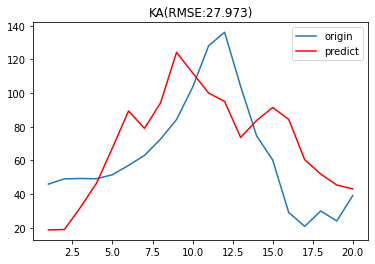

In [63]:
show_x = data_123_te
show_y = data_457_te_y
show_l = 20
column = 0
net = net2
net.eval()
net.to("cpu")
criterion = torch.nn.MSELoss()
# predict = net(show_x)
# predict = predict.data.numpy()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)
predict_show = []
y_show = []
for batch in test_loader:
    (
        s_x,
        s_y,
        _,
        _,
        _,
        _,
    ) = batch
    predict = net(s_x)
    pred2 = predict.detach().numpy()
    predict_show.append(pred2)
    trainloss = criterion(predict, s_y)
    y_s = s_y.detach().numpy()
    y_show.append(y_s)
predict_show = np.array(predict_show)
y_show = np.array(y_show)
# MSE_show = criterion(predict[:,column], show_y[:,column])
MSE_show = criterion(
    torch.Tensor(predict_show[:, :, column]), torch.Tensor(y_show[:, :, column])
)
predict = predict.data.numpy()
# 建立等差数列，（起始，终止，个数）
x = np.linspace(1, show_l, show_l)

plt.title("KA(RMSE:" + str("%.5g" % torch.sqrt(MSE_show)) + ")")
# plt.plot(x , show_y[:,column], label='origin')
plt.plot(x, show_y[:, column], label="origin")
# plt.plot(x, predict[:,column], color='red', label='predict')
plt.plot(x, predict_show[:, 0, column], color="red", label="predict")
plt.legend()
plt.show()

In [55]:
adataset_kmmf = {}
data_457_te_y = np.array(data_457_te_y)
adataset_kmmf["GT"] = data_457_te_y
adataset_kmmf["Preds"] = predict_show
np.save("../data/exportdata/low_nl_intj_s1f4_s3f4.npy", adataset_kmmf)

In [56]:
from scipy import io

mat = np.load("../data/exportdata/low_nl_intj_s1f4_s3f4.npy", allow_pickle=True)
io.savemat("../data/exportdata/low_nl_intj_s1f4_s3f4.mat", {"variables": mat})